In [1]:
import pandas as pd
import math
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import datetime as dt
import networkx as nx
from matplotlib import pylab
import sys
import unittest
import time
import datetime
import seaborn as sns
from matplotlib.widgets import Button

In [2]:
sys.path.append('../code')

In [3]:
import generateGraphs as gg

In [4]:
df = pd.read_csv("../data/CometLandingFixed.csv",
                 dtype={"id_str": str, "in_reply_to_user_id_str": str, "from_user_id_str": str,
                        "in_reply_to_status_id_str": str, "user_followers_count": "Int64",
                        "user_friends_count": "Int64", "geo_coordinates": str}, parse_dates=['created_at']
                 )


In [5]:
df

,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str,specific_applications,applications
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56...",Twitter Web Client,Twitter
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Websites,Twitter
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPad,Twitter
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices...",Twitter for Android,Twitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",TweetCaster for Android,TweetCaster for Android
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",Twitter for Android Tablets,Twitter
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter Web Client,Twitter
77305,532460148238090240,nsentse,7 hours of waiting #CometLanding,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,20434005,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3693655850...,200,267,http://twitter.com/nsentse/statuses/5324601482...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter


Data Cleaning: <br>
The duplicated records are first removed.  Then, records without any of the following essetial fields (ie. value = Nan) are also removed: id_str (Tweet ID), from_user_id_str (User ID), text (Tweet text), entities_str (information including hashtags used, users mentioned and used URL).  These fields are considered essential for analysing the dataset that we decide to remove records without any of these fields as they will not be usable for analysis.  The data are also filtered so that only tweets between 2014-11-12 and 2014-12-05 inclusively remain.  Additional filtering is also done to make sure all tweets in the dataset contain the hashtag "CometLanding" of any case as this should be the criteria of the tweets being in this dataset.

New Fields: <br>
New columns "specific_applications" and "applications" are added to store the application used for sending the tweet. "specific_applications" treated the same application for different devices as distinct applications (eg. Twitter for iPhone is different from Twitter for Android) while "applications" generalize them as the same application (eg. Twitter for iPhone and Twitter for Android are stored as Twitter).  There are also new columns added for information related to the user being retweeted: "retweet_user_id_str" (Retweeted User ID), "retweet_user_screen_name" (Retweeted User screen name), "retweet_user_name" (Retweeted User username).

Refine ID: <br>
"id_str" is refined with the "status_url".  Specifically, its value is replaced with the last 18 characters of "status_url".  This decision starts from the observation that the original values of "id_str" of 18 digits are not unique ie. there are some tweets that share the same ID, which should not be the case.  Then, it is observed that the URL in "status_url" always end with also 18 digits, and the first 15 digits are always the same as that of "id_str".  In addition to the fact the the last 3 digits of "id_str" are always zeroed, it is concluded that the original value of "id_str" are merely the 15 digits prefix of the actual Tweet ID with the last 3 zeroed, and that the one in "status_url" is the actual, full Tweet ID.  This conclusion is also supported by the fact that all values in "status_url" are unique.  Thus, the substitution is made for tweets with non-empty "status_url" field, or else "id_str" field remains the same.

In [9]:
len(df)


77307

In [10]:
df.dtypes


id_str                                    object
from_user                                 object
text                                      object
created_at                   datetime64[ns, UTC]
geo_coordinates                           object
user_lang                                 object
in_reply_to_user_id_str                   object
in_reply_to_screen_name                   object
from_user_id_str                          object
in_reply_to_status_id_str                 object
source                                    object
profile_image_url                         object
user_followers_count                       Int64
user_friends_count                         Int64
status_url                                object
entities_str                              object
specific_applications                     object
applications                              object
dtype: object

In [12]:
reply_df = df[["in_reply_to_user_id_str",
               "in_reply_to_screen_name", "in_reply_to_status_id_str"]]


In [13]:
reply_df


,in_reply_to_user_id_str,in_reply_to_screen_name,in_reply_to_status_id_str
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
77302,NaN,NaN,NaN
77303,NaN,NaN,NaN
77304,NaN,NaN,NaN
77305,NaN,NaN,NaN


In [14]:
# reply
def isreply(tweet):
    if not pd.isna(tweet):
        print(tweet)


In [13]:
total_replies = df[pd.notna(df["in_reply_to_user_id_str"])]  # replies


In [16]:
len(total_replies.index)  # amount of replies


1724

In [17]:
# print all replies
replies = reply_df["in_reply_to_user_id_str"].map(isreply)


11348282
19442947
253536357
253536357
64643056
33602654
1691515789
19402238
529722897
2294593507
41333964
253536357
66162716
59220577
253536357
1273487113
253536357
17842366
26030180
24129206
14526045
21436960
1969346438
253536357
253536357
2232463302
1438925534
15808765
472670056
2590415228
254659730
17384099
177594666
46959037
32520240
443080433
412396499
208442526
86070159
21436960
253536357
253536357
253536357
253536357
208442526
35233873
376790816
404818828
14800111
622113
1266281
2294593507
372434360
329600057
972651
208442526
168090600
246693449
27650674
208442526
1941637627
43024906
86336234
208442526
19903360
2868449663
47306483
371152085
2894572724
106442779
208442526
364423298
253536357
43024906
85751142
208442526
4620451
3108351
41712825
75052666
5402612
2254751592
629637909
21584325
110462645
208442526
5402612
14606395
208442526
75052666
1041442471
119473816
1435461
208442526
229632990
75052666
34800396
32498911
18505048
208442526
208442526
129673790
75052666
114085696
673

In [18]:
def getAllReplies(df):
    total_replies_df = df[pd.notna(df['in_reply_to_user_id_str'])]
    return total_replies_df

def getAllRetweets(df):
    nan_reply_user_id_df = df[pd.isna(df['in_reply_to_user_id_str'])]
    retweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(
        lambda x: True if re.search("^RT @.*", x)else False)]
    return retweet_only_df

def getAllTweets(df):
    nan_reply_user_id_df = df[pd.isna(df['in_reply_to_user_id_str'])]
    tweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(
        lambda x: False if re.search("^RT @.*", x)else True)]
    return tweet_only_df
    
total_replies_df = getAllReplies(df)

retweet_only_df = getAllRetweets(df)

tweet_only_df = getAllTweets(df)

In [19]:
total_replies_df


,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str,specific_applications,applications
29,540896030628532224,einfachbloggen,Congrats MT @NASA: #Orion's flying free for th...,2014-12-05 15:50:37+00:00,NaN,de,11348282,NASA,398268735,540891938275467000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5098209126...,191,199,http://twitter.com/einfachbloggen/statuses/540...,"{""hashtags"":[{""text"":""Orion"",""indices"":[19,25]...",Twitter for iPhone,Twitter
64,540776048414031872,gwittrapp,@nathanbroon last month you tagged 10 tweets w...,2014-12-05 07:53:51+00:00,NaN,en-gb,19442947,nathanbroon,1673116172,NaN,"<a href=""http://gwittr.com"" rel=""nofollow"">Gwi...",http://pbs.twimg.com/profile_images/3788000004...,139,531,http://twitter.com/gwittrapp/statuses/54077604...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",Gwittr Writer,Gwittr Writer
108,540556460443594752,acolliver615,"@ESA_Rosetta keep sending pictures, they're ep...",2014-12-04 17:21:17+00:00,"loc: 39.2076777,-83.6107315",en,253536357,ESA_Rosetta,2260971996,540554322535534000,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/5329781788...,56,364,http://twitter.com/acolliver615/statuses/54055...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Android,Twitter
127,540488420062429185,WillemelliW,@ESA_Rosetta kan een puntje zuigen aan de vers...,2014-12-04 12:50:55+00:00,NaN,en,253536357,ESA_Rosetta,1201626438,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3283427317...,29,113,http://twitter.com/WillemelliW/statuses/540488...,"{""hashtags"":[{""text"":""OrionLaunch"",""indices"":[...",Twitter Web Client,Twitter
128,540482901624647682,Chapuler38,@RT_com @NASA Looking for miracles? Then #orio...,2014-12-04 12:29:00+00:00,NaN,en,64643056,RT_com,205378951,540481604666556000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/4434806916...,466,477,http://twitter.com/Chapuler38/statuses/5404829...,"{""hashtags"":[{""text"":""orion"",""indices"":[41,47]...",Twitter for iPhone,Twitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76974,532460309639094272,whereisyvette,@purplefroglet also FYI I am bringing prosecco...,2014-11-12 09:10:05+00:00,NaN,en,18061411,purplefroglet,123421220,532459942679429000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/980798471/...,1820,944,http://twitter.com/whereisyvette/statuses/5324...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter
77198,532460192571883520,arrayson,â€œ@charlieowen4: Seven hours until Philae lan...,2014-11-12 09:09:37+00:00,NaN,en-gb,56183928,charlieowen4,1912388480,532459997771202000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/4887538097...,483,596,http://twitter.com/arrayson/statuses/532460192...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter
77250,532460171843629056,drfarres,@ESA_Rosetta congratulatins for the separation...,2014-11-12 09:09:32+00:00,NaN,ca,253536357,ESA_Rosetta,190801607,532459086462615000,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/2312825800...,159,352,http://twitter.com/drfarres/statuses/532460171...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter
77254,532460170513625088,cocoy,â€œ@verge: Rosetta's probe just began its prec...,2014-11-12 09:09:31+00:00,NaN,en,275686563,verge,1147491,532459464155484000,"<a href=""http://itunes.apple.com/us/app/twitte...",http://pbs.twimg.com/profile_images/4849003519...,4493,1997,http://twitter.com/cocoy/statuses/5

In [20]:
def getAllRetweetReplies(total_replies_df):
    retweet_replies = total_replies_df[total_replies_df['text'].apply(
        lambda x: True if re.search('^RT @.*', x) else False)]
    return retweet_replies

def getAllTweetReplies(total_replies_df):
    tweet_replies = total_replies_df[total_replies_df['text'].apply(
        lambda x: False if re.search('^RT @.*', x) else True)]
    return tweet_replies

retweet_replies = getAllRetweetReplies(total_replies_df)

tweet_replies = getAllTweetReplies(total_replies_df)

In [21]:
nan_reply_user_id_df = df[pd.isna(df['in_reply_to_user_id_str'])]
retweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(
    lambda x: True if re.search("^RT @.*", x)else False)]
tweet_only_df = nan_reply_user_id_df[nan_reply_user_id_df['text'].apply(
    lambda x: False if re.search("^RT @.*", x)else True)]


In [22]:
retweet_only_df


,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str,specific_applications,applications
0,540930409279008768,amika0078788556,RT @VersaTechnology: Congratulations @Philae20...,2014-12-05 18:07:14+00:00,NaN,en,NaN,NaN,1297570116,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/3555068293...,425,113,http://twitter.com/amika0078788556/statuses/54...,"{""hashtags"":[{""text"":""Philae"",""indices"":[49,56...",Twitter Web Client,Twitter
2,540929998388211713,MHuuskoL,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:05:36+00:00,NaN,en,NaN,NaN,574434762,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",http://pbs.twimg.com/profile_images/4973510588...,215,310,http://twitter.com/MHuuskoL/statuses/540929998...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPad,Twitter
3,540929346878599168,SaraGomezAranci,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:03:00+00:00,NaN,fr,NaN,NaN,1057356487,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/5391705804...,741,310,http://twitter.com/SaraGomezAranci/statuses/54...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for iPhone,Twitter
4,540929229052203008,CBCDay6,RT @shaunmajumder: Feels good to be the @CBCDa...,2014-12-05 18:02:32+00:00,NaN,en,NaN,NaN,177276897,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/4590694303...,4331,2098,http://twitter.com/CBCDay6/statuses/5409292290...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices...",Twitter for Android,Twitter
5,540928707947671555,MBernacconi,RT @EUCouncil: After the #CometLanding - Astro...,2014-12-05 18:00:28+00:00,NaN,en,NaN,NaN,47907492,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/5331943059...,317,478,http://twitter.com/MBernacconi/statuses/540928...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter Web Client,Twitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77300,532460149668343808,m0cvo,RT @ConversationUK: BREAKING: Philae lander ha...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,103211582,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5001938819...,1430,845,http://twitter.com/m0cvo/statuses/532460149668...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Android Tablets,Twitter
77301,532460149215350784,ipanice,RT @esa: '@Philae2014 is gone - it's on its pa...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,39744088,NaN,"<a href=""http://itunes.apple.com/us/app/twitte...",http://pbs.twimg.com/profile_images/1667935129...,157,350,http://twitter.com/ipanice/statuses/5324601492...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Mac,Twitter
77303,532460148451581952,atieyK,RT @ObservingSpace: Weâ€™ve been waiting 10 ye...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,58303715,NaN,"<a href=""https://twitter.com/download/android""...",http://pbs.twimg.com/profile_images/5057311637...,354,1088,http://twitter.com/atieyK/statuses/53246014845...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",Twitter for Android Tablets,Twitter
77304,532460148254470144,j0nny5,RT @maxplanckpress: Accomazzo (flight director...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,17914863,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/89991673/j...,92,63,http://twitter.com/j0nny5/statuses/53246014825...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter Web Client,Twitter


In [23]:
tweet_only_df


,id_str,from_user,text,created_at,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,status_url,entities_str,specific_applications,applications
1,540930042700656640,ChrisDMarshall,CometWatch 2 December Â» Rosetta - ESA's comet...,2014-12-05 18:05:46+00:00,NaN,en,NaN,NaN,42201214,NaN,"<a href=""https://dev.twitter.com/docs/tfw"" rel...",http://pbs.twimg.com/profile_images/228087980/...,347,1286,http://twitter.com/ChrisDMarshall/statuses/540...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter for Websites,Twitter
6,540928513906589696,LukeGolds,USA Â» NEWS Â» HOT NEWS 828 comet landing Phi...,2014-12-05 17:59:42+00:00,NaN,en,NaN,NaN,619629656,NaN,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",http://pbs.twimg.com/profile_images/2344739619...,350,<NA>,http://twitter.com/LukeGolds/statuses/54092851...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",IFTTT,IFTTT
9,540925590111789056,shaunmajumder,Feels good to be the @CBCDay6 champion beating...,2014-12-05 17:48:05+00:00,NaN,en,NaN,NaN,17680518,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1312790905...,67013,1973,http://twitter.com/shaunmajumder/statuses/5409...,"{""hashtags"":[{""text"":""MiniMansbridge"",""indices...",Twitter for iPhone,Twitter
10,540925056533413888,EUCouncil,After the #CometLanding - Astronaut @astro_luc...,2014-12-05 17:45:58+00:00,NaN,en,NaN,NaN,206717989,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",http://pbs.twimg.com/profile_images/4838611162...,52050,360,http://twitter.com/EUCouncil/statuses/54092505...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",Twitter Web Client,Twitter
11,540924908797448193,LukeGolds,USA Â» NEWS Â» HOT NEWS 534 comet landing The...,2014-12-05 17:45:22+00:00,NaN,en,NaN,NaN,619629656,NaN,"<a href=""http://ifttt.com"" rel=""nofollow"">IFTT...",http://pbs.twimg.com/profile_images/2344739619...,350,<NA>,http://twitter.com/LukeGolds/statuses/54092490...,"{""hashtags"":[{""text"":""cometlanding"",""indices"":...",IFTTT,IFTTT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77287,532460156567580672,JoeGrish1,"And go! Philae separates from Rosetta, but sig...",2014-11-12 09:09:28+00:00,NaN,pl,NaN,NaN,2387053214,NaN,"<a href=""http://twitterfeed.com"" rel=""nofollow...",http://pbs.twimg.com/profile_images/4441120804...,173,38,http://twitter.com/JoeGrish1/statuses/53246015...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",twitterfeed,twitterfeed
77290,532460155859120128,charliecbs,It will take seven hours for the #probe to fal...,2014-11-12 09:09:28+00:00,NaN,en,NaN,NaN,169495645,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/3788000006...,2163,66,http://twitter.com/charliecbs/statuses/5324601...,"{""hashtags"":[{""text"":""probe"",""indices"":[33,39]...",Twitter for iPhone,Twitter
77297,532460154482999296,worldbreakingn,"And go! Philae separates from Rosetta, but sig...",2014-11-12 09:09:28+00:00,NaN,pl,NaN,NaN,2309819160,NaN,"<a href=""http://twitterfeed.com"" rel=""nofollow...",http://pbs.twimg.com/profile_images/4270311610...,532,472,http://twitter.com/worldbreakingn/statuses/532...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",twitterfeed,twitterfeed
77302,532460149084930049,ABForScience,This means that the actual landing will be ar...,2014-11-12 09:09:26+00:00,NaN,en,NaN,NaN,2333122519,NaN,"<a href=""http://www.tweetcaster.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/4320695593...,155,212,http://twitter.com/ABForScience/statuses/53246...,"{""hashtags"":[{""text"":""CometLanding"",""indices"":...",TweetCaster for Android,TweetCaster for Android


In [24]:
len(retweet_replies.index)  # replies that contain retweets


30

In [25]:
len(tweet_replies.index)  # replying other tweets


1694

In [26]:
retweet_total = df[df['text'].apply(
    lambda x: True if re.search('^RT @.*', x) else False)]
tweet_total = df[df['text'].apply(
    lambda x: False if re.search('^RT @.*', x) else True)]


In [27]:
len(retweet_total.index)  # Total retweets


59959

In [28]:
len(tweet_total.index)  # Total tweets


17348

In [29]:
retweet_only = len(retweet_total.index) - len(retweet_replies.index)


In [30]:
tweet_only = len(tweet_total.index) - len(tweet_replies.index)


In [31]:
replies_only = len(total_replies.index)


In [32]:
len(retweet_only_df)


59929

In [33]:
len(tweet_only_df)


15654

In [34]:
replies_only


1724

In [35]:
def getNoOfUniqueUsers(df):
    average_different_users_tweet = df.groupby(
    ["from_user_id_str"]).agg(["count"])["from_user"]
    average_different_users_tweet.mean()
    average_different_users_tweet.sort_values(by="count", ascending=False)
    man = average_different_users_tweet["count"].tolist()
    return len(man)


In [36]:
uniqueUsers = getNoOfUniqueUsers(df)


In [37]:
average_retweets_by_a_user = len(retweet_only_df) / uniqueUsers 
average_tweets_by_a_user = len(tweet_only_df) / uniqueUsers
average_replies_by_a_user = len(total_replies_df) / uniqueUsers


In [38]:
print("Average retweets by a user: " + str(average_retweets_by_a_user))
print("Average tweets by a user: " + str(average_tweets_by_a_user)) #(excluding retweets and replies)
print("Average replies by a user: " + str(average_replies_by_a_user))


Average retweets by a user: 1.193424406563645
Average tweets by a user: 0.3117333120917636
Average replies by a user: 0.034331687111677556


In [59]:
df = pd.read_csv("../data/CometLandingFixed.csv",
                 dtype={"id_str": str, "in_reply_to_user_id_str": str, "from_user_id_str": str,
                        "in_reply_to_status_id_str": str, "user_followers_count": "Int64",
                        "user_friends_count": "Int64", "geo_coordinates": str}, parse_dates=['created_at']
                 )

In [60]:
class Tests(unittest.TestCase):
   # Test on if filtering of dates is functioning properly.
   def test_one(self):
      start_date = time.mktime(datetime.datetime.strptime('2014/11/12', "%Y/%m/%d").timetuple())
      end_date = time.mktime(datetime.datetime.strptime('2014/12/06', "%Y/%m/%d").timetuple())
      dfTest = filterOutDates(df)
      for date in dfTest['created_at']:
          self.assertEqual(True, (date.timestamp() >= start_date))
          self.assertEqual(True, (date.timestamp() < end_date))
   pass
      
   # Test on if filtering of duplicates and null records is functioning properly.
   def test_two(self):
      noOfRecordsBefore = len(df)
      dfTest = removeDuplicatesNullRecords(df)
      noOfRecordsAfter = len(dfTest)
      self.assertEqual(noOfRecordsBefore, noOfRecordsAfter)
   pass

   # Test on if only replies can be found.
   def test_three(self):
      replies = getAllReplies(df)
      for i in replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))
   pass

   # Test on if all retweets can be found.
   def test_four(self):
      retweets = getAllRetweets(df)
      for i in retweets['text']:
         self.assertEqual(True, i.startswith("RT @"))
   pass

   # Test on if all tweets can be found.
   def test_five(self):
      tweets = getAllTweets(df)
      for i in tweets['text']:
         self.assertEqual(False, i.startswith("RT @"))
   pass

   # Test on if only retweet replies can be found.
   def test_six(self):
      retweet_replies = getAllRetweetReplies(getAllReplies(df))
      for i in retweet_replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))
      for i in retweet_replies['text']:
         self.assertEqual(True, i.startswith("RT @"))
   pass

   # Test on if only tweet replies can be found.
   def test_seven(self):
      tweet_replies = getAllTweetReplies(getAllReplies(df))
      for i in tweet_replies['in_reply_to_user_id_str']:
         self.assertEqual(True, pd.notna(i))
      for i in tweet_replies['text']:
         self.assertEqual(False, i.startswith("RT @"))
   pass

   # Tests that all replies are kept when they are split.
   def test_eight(self):
      replies = getAllReplies(df)
      tweet_replies = getAllTweetReplies(replies)
      retweet_replies = getAllRetweetReplies(replies)
      self.assertEqual(len(replies), len(tweet_replies) + len(retweet_replies))
   pass

   # Tests that unique users amount is found.
   def test_nine(self):
      uniqueUsers = getNoOfUniqueUsers(df)
      uniqueUsersTest = len(df["from_user_id_str"].unique())
      self.assertEqual(uniqueUsers, uniqueUsersTest)
   pass

   # Tests that unique hashtags are found.
   def test_ten(self):
      allHashtags = getListOfAllHashTags()
      unique = getListOfUniqueHashtags(allHashtags)
      newunique = pd.Series(allHashtags)
      unique2 = newunique.unique()

      self.assertEqual(len(unique) < len(allHashtags), True)
      for i in range(len(unique)):
         self.assertEqual(unique[i], unique2[i])
      
   # Tests that top 25 hashtags are the same found in functions.
   def test_eleven(self):
      allHashtags = getListOfAllHashTags()
      unique = getListOfUniqueHashtags(allHashtags)
      newdf = createDataFrameOfHashtagsAndFills(unique, allHashtags)
      newdf2 = newdf.reset_index()
      for i in range(25):
         self.assertEqual(newdf2['Frequency'][i], allHashtags.count(newdf2['Hashtags'][i]))
   pass


In [61]:
def suite():
 loader = unittest.TestLoader()
 testsuite = loader.loadTestsFromTestCase(Tests)
 return testsuite

In [62]:
def test():
 testsuite = suite()
 runner = unittest.TextTestRunner(sys.stdout, verbosity=2)
 result = runner.run(testsuite)

In [63]:
test()

test_eight (__main__.Tests) ... ok
test_eleven (__main__.Tests) ... 

<ipython-input-39-b077fb34ee3f>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency'][index] += 1


ok
test_five (__main__.Tests) ... ok
test_four (__main__.Tests) ... ok
test_nine (__main__.Tests) ... ok
test_one (__main__.Tests) ... ok
test_seven (__main__.Tests) ... ok
test_six (__main__.Tests) ... ok
test_ten (__main__.Tests) ... ok
test_three (__main__.Tests) ... ok
test_two (__main__.Tests) ... ok

----------------------------------------------------------------------
Ran 11 tests in 22.976s

OK


In [64]:


# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
#Network X

replies_network = nx.Graph()
seenNodes_replies = set()

for index, row in total_replies_df.iterrows():
    node_1 = row['in_reply_to_screen_name']
    if node_1 not in seenNodes_replies and node_1 is not None:
        replies_network.add_node(node_1)
        seenNodes_replies.add(node_1)
        
    node_2 = row['from_user']
    if node_2 not in seenNodes_replies and node_2 is not None :
        replies_network.add_node(node_2)
        seenNodes_replies.add(node_2)
        
    replies_network.add_edge(node_1,node_2)
  
    
    print(row['in_reply_to_screen_name'], row['from_user'])



NASA einfachbloggen
nathanbroon gwittrapp
ESA_Rosetta acolliver615
ESA_Rosetta WillemelliW
RT_com Chapuler38
NASA_Orion TonyPethtel
ReginePetersen mazmanian
ScienceNews IsidoraBojovicc
treyhughett1 cunningham_dc
Philae_Ptolemy masanorimusic
rtistforhire rtistforhire
ESA_Rosetta mixelaneo
carolynporco LaTambourine
teobesta teobesta
ESA_Rosetta masanorimusic
GummyTraveler GummyTraveler
ESA_Rosetta einfachbloggen
Discovery Nijin_Koshy
lcfleming leppx
universetoday kpcuk
me_too Melissandre_L
esa EvidenceBDave
JohnRMoffitt s0cialblast
ESA_Rosetta einfachbloggen
ESA_Rosetta kichyedesh
FarSight3 astro_geo
AmyAmylou1993 AmyAmylou1993
CoryBooker the_amphibian
fezIet AmyAmylou1993
nm_edm nm_edm
EuropeanSpace LordBexar
esaoperations ElaineHansen888
nitrogen_15 MonicaGrady
RogerHighfield davidshukmanbbc
JFKLibrary Uzu_Brady_3000
royalmailnews mrsdenyer
SeekTwit VanessaJades1
Philae2014 KarewiKaulissch
DLR_en einfachbloggen
esa Sannsibble
ESA_Rosetta BorisSbarufatti
ESA_Rosetta ononerail
ESA_Rosett

Suntimes reftpt
astVintageSpace qrs
Philae2014 Innovasian
ESA_nl FransF72
Philae2014 EuroGeosciences
nationaltrust picto65
senorwatanabe JeffreyGuterman
gavreilly DrKeithRedmond
Philae2014 johnrogersatty
Philae2014 UAbendland
esa shiroibara
ESA_Rosetta baboom15
esa SouthportReport
Philae2014 edwinvanbalen
ESA_Rosetta twcMariaLaRosa
Philae2014 Step_981
Philae2014 jackvweston
paulcoxon theglitzkrieg
ESA_Rosetta vmiss33
Philae2014 kennethmosop
BBCBreaking TomLewis29
Philae2014 pssalgado
Philae2014 CelestiniaSpace
CNNLightYears stukennedymusic
ESA_Rosetta KacosPhoniquo
Philae2014 JerelDamon
Philae2014 patriciahizon
esaoperations Rodpac
Philae2014 NeveMaslakovic
Philae2014 palcschemistry
Philae2014 _kavita
Philae2014 macrae2100
ESA_Rosetta gruloos
PlanetarioMad Feralvamar
Paleo_Bonegirl Paleo_Bonegirl
mediainaf Elisa_Buson
jm22381 Lexy_Black
Philae2014 TheDuudee_
Philae2014 vinyl_beast
mec337 mec337
SPACEdotcom riaro
ESA_Rosetta withstory
ESA_Rosetta LionelPonce
Channel4News GeorginaOgrady


maxplanckpress masanorimusic
kazufukuda kittenblue0706
OneMinuteBriefs JamesHWalker9
Philae2014 brobof
AlicesAstroInfo marginal_error
nytimes lisablas
NoorulAinur angkasamalaysia
poweredbySAM BenJGlad
teobesta teobesta
Jeremy_Starship TrollULike
elia_barcelo Nitrobencen0
kumitaguchi Fowlhouses
Philae2014 EdCostar
thecraftmill thecraftmill
AlicesAstroInfo marginal_error
teobesta teobesta
Philae2014 johnniemojo
Philae2014 mr_skylord
Philae2014 Nick_Ilic
esaoperations chris_tibbs
esa MinnieMach
nchazarra elefenor
SungrazerComets brainimpact
Philae2014 isapinza
RAGreeneCNN L4zick
AboutTheBBC LinkPlugging
asoundeffect cimarquez
ESA_Rosetta 2m_marco
ESA_Rosetta darrenmaule
GarethJonesTV JeffSpangle
Stirn DLR_de
nchazarra elefenor
LaurenMoorhouse RAGreeneCNN
Philae2014 isapinza
camillebordenet t0adscroak
WSI_Bergamo jack_shillito
barneyfarmer RossHaffenden
kunstbiss kunstbiss
Philae2014 _Amanda_n1
BIS_spaceflight OberthMuseum
tsartas_ napocornejo
DrStuClark morten_pape
MarilMontero viruvizzz


In [65]:
retweet_network = nx.Graph()
seenNodes_retweet = set()
# retweet_list = retweet_only_df['text'].apply(lambda x: x.split(":")[0][2:]) # slice and split to get retweet users



for index, row in retweet_only_df.iterrows():
    node_1 = row["from_user"]
    if node_1 not in seenNodes_retweet and node_1 is not None:
        retweet_network.add_node(node_1)
        seenNodes_retweet.add(node_1)
        
    node_2 = row["text"].split(":")[0][2:]
    if node_2 not in seenNodes_retweet and node_2 is not None:
        retweet_network.add_node(node_2)
        seenNodes_retweet.add(node_2)
    
    retweet_network.add_edge(node_1,node_2)

In [66]:
mentions_network = nx.Graph()
seenNodes_mentions = set()

for index, row in df.iterrows():
    
    node_1 = row["from_user"]
    if node_1 not in seenNodes_mentions and node_1 is not None:
        mentions_network.add_node(node_1)
        seenNodes_mentions.add(node_1)
        
    node_2 = row["text"]
    match = re.search("@[A-Za-z0-9_]* ", node_2)
    if match:
        if match.group() not in seenNodes_mentions and match.group() is not None:
            mentions_network.add_node(match.group())
            seenNodes_mentions.add(match.group())
        
        if match.group() == "@EUCouncil":
            print(match.group())
            
        mentions_network.add_edge(node_1,match.group())

In [67]:
# https://stackoverflow.com/questions/17381006/large-graph-visualization-with-python-and-networkx
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(800,800), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos, edge_color="r")
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(-1*xmax, xmax)
    plt.ylim(-1*ymax, ymax)

    plt.savefig(file_name)
    pylab.close()
    del fig
    
# save_graph(replies_network,"../images/replies_network.pdf")
# save_graph(retweet_network,"../images/retweet_network.pdf")
# save_graph(mentions_network,"../images/mentions_network.pdf")

In [68]:

date_raw2 = df

In [69]:


day = date_raw2.set_index('created_at').groupby(pd.Grouper(freq='D'))



In [70]:


day_labels = [str(ts.strftime("%d/%m"))
               for ts in day.count()["id_str"].index.tolist()]


day_data = day.count()["id_str"].tolist()




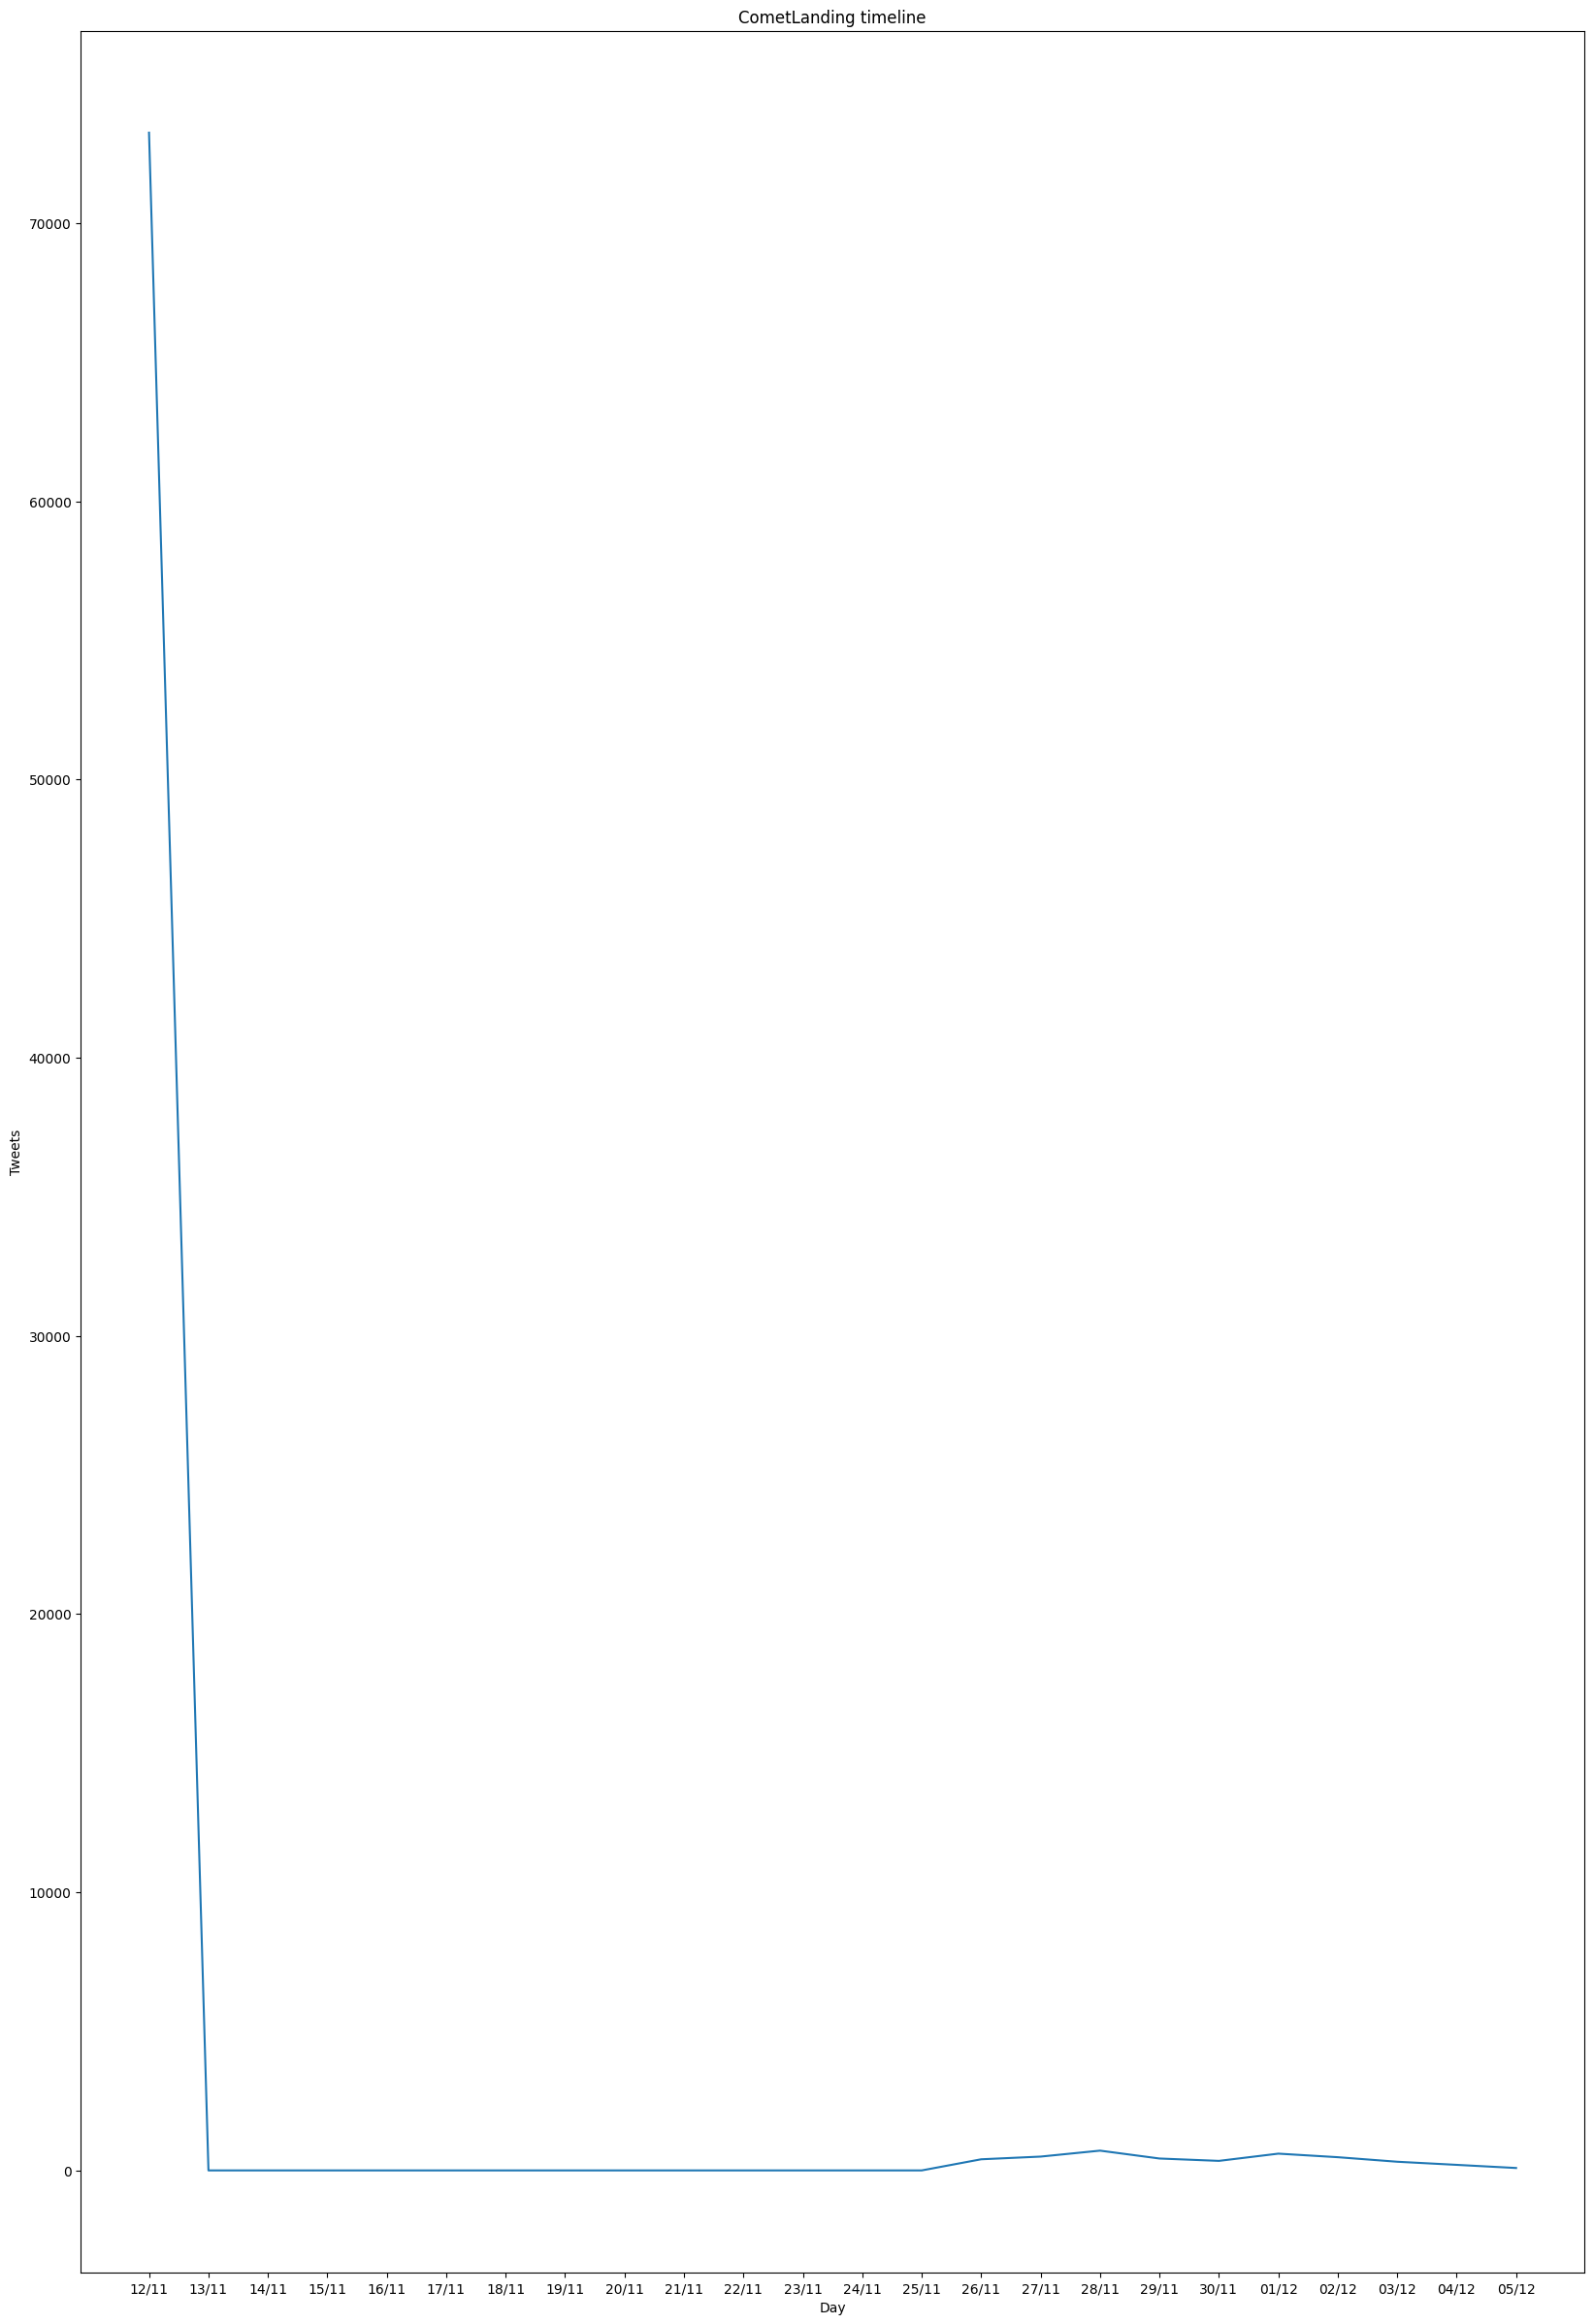

In [71]:
#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
y = day_data
x = day_labels

plt.rcParams["figure.figsize"] = (20,30)

plt.title("CometLanding timeline")
plt.xlabel("Day")
plt.ylabel("Tweets")


plt.plot(x, y)
plt.show()

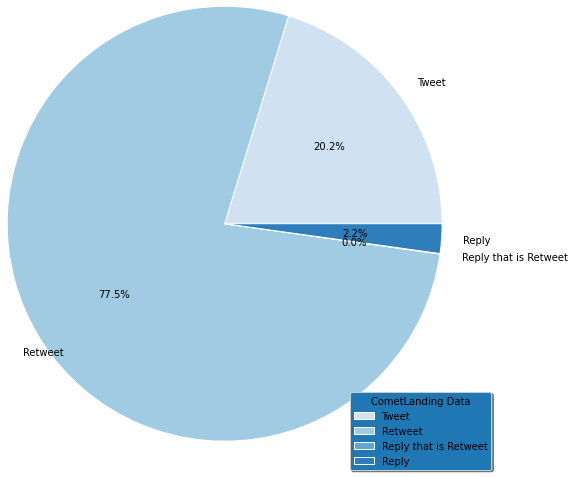

<Figure size 360x360 with 0 Axes>

In [5]:
plt.rcParams["figure.figsize"] = (5,5)
gg.createTweetsTypeChart(df)
plt.show()
plt.clf()

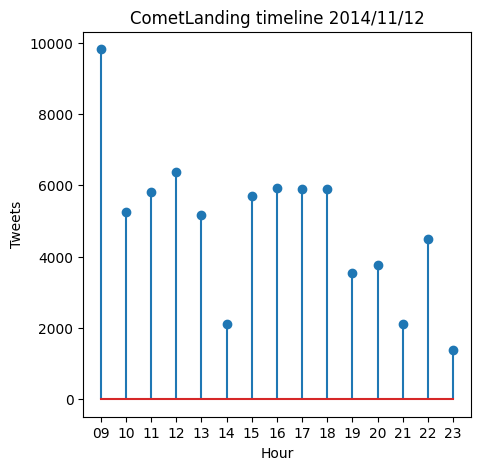

<Figure size 500x500 with 0 Axes>

In [73]:
gg.createActiveDayTimelinePlot(df)
plt.show()
plt.clf()

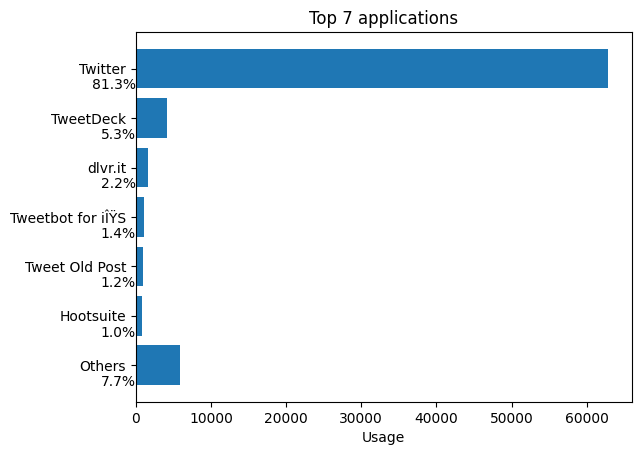

<Figure size 640x480 with 0 Axes>

In [74]:
gg.createApplicationChart(df)
plt.show()
plt.clf()

C:\Users\msmai\OneDrive\桌面\St Andrews\CS2006\Python\CS2006P\notebooks\../code\generateGraphs.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Frequency'][index] += 1


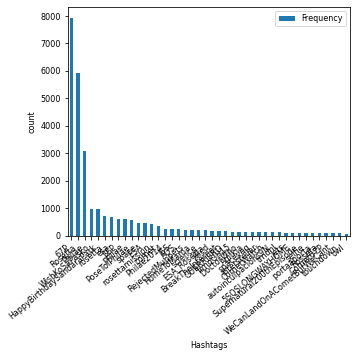

<Figure size 360x360 with 0 Axes>

In [6]:
gg.createHashtagChart("../data/CometLandingFixed.json")
plt.show()
plt.clf()

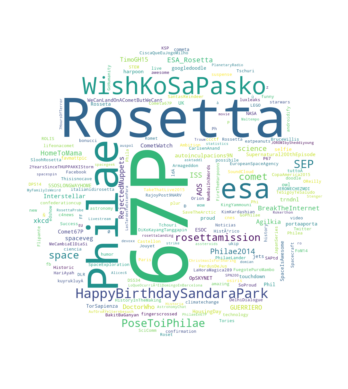

<Figure size 640x480 with 0 Axes>

In [75]:
gg.createWordCloud(gg.getListOfAllHashTags("../data/CometLandingFixed.json"))
plt.show()
plt.clf()

For the analysis of the most popular hashtags used, we decided to exclude "CometLanding" of any case as all tweets in the dataset should have this hashtag which will automatically make it the most popular hashtag.  As shown in the word cloud, the top 3 most popular hastags are "67P", "Rosetta" and "Philae".

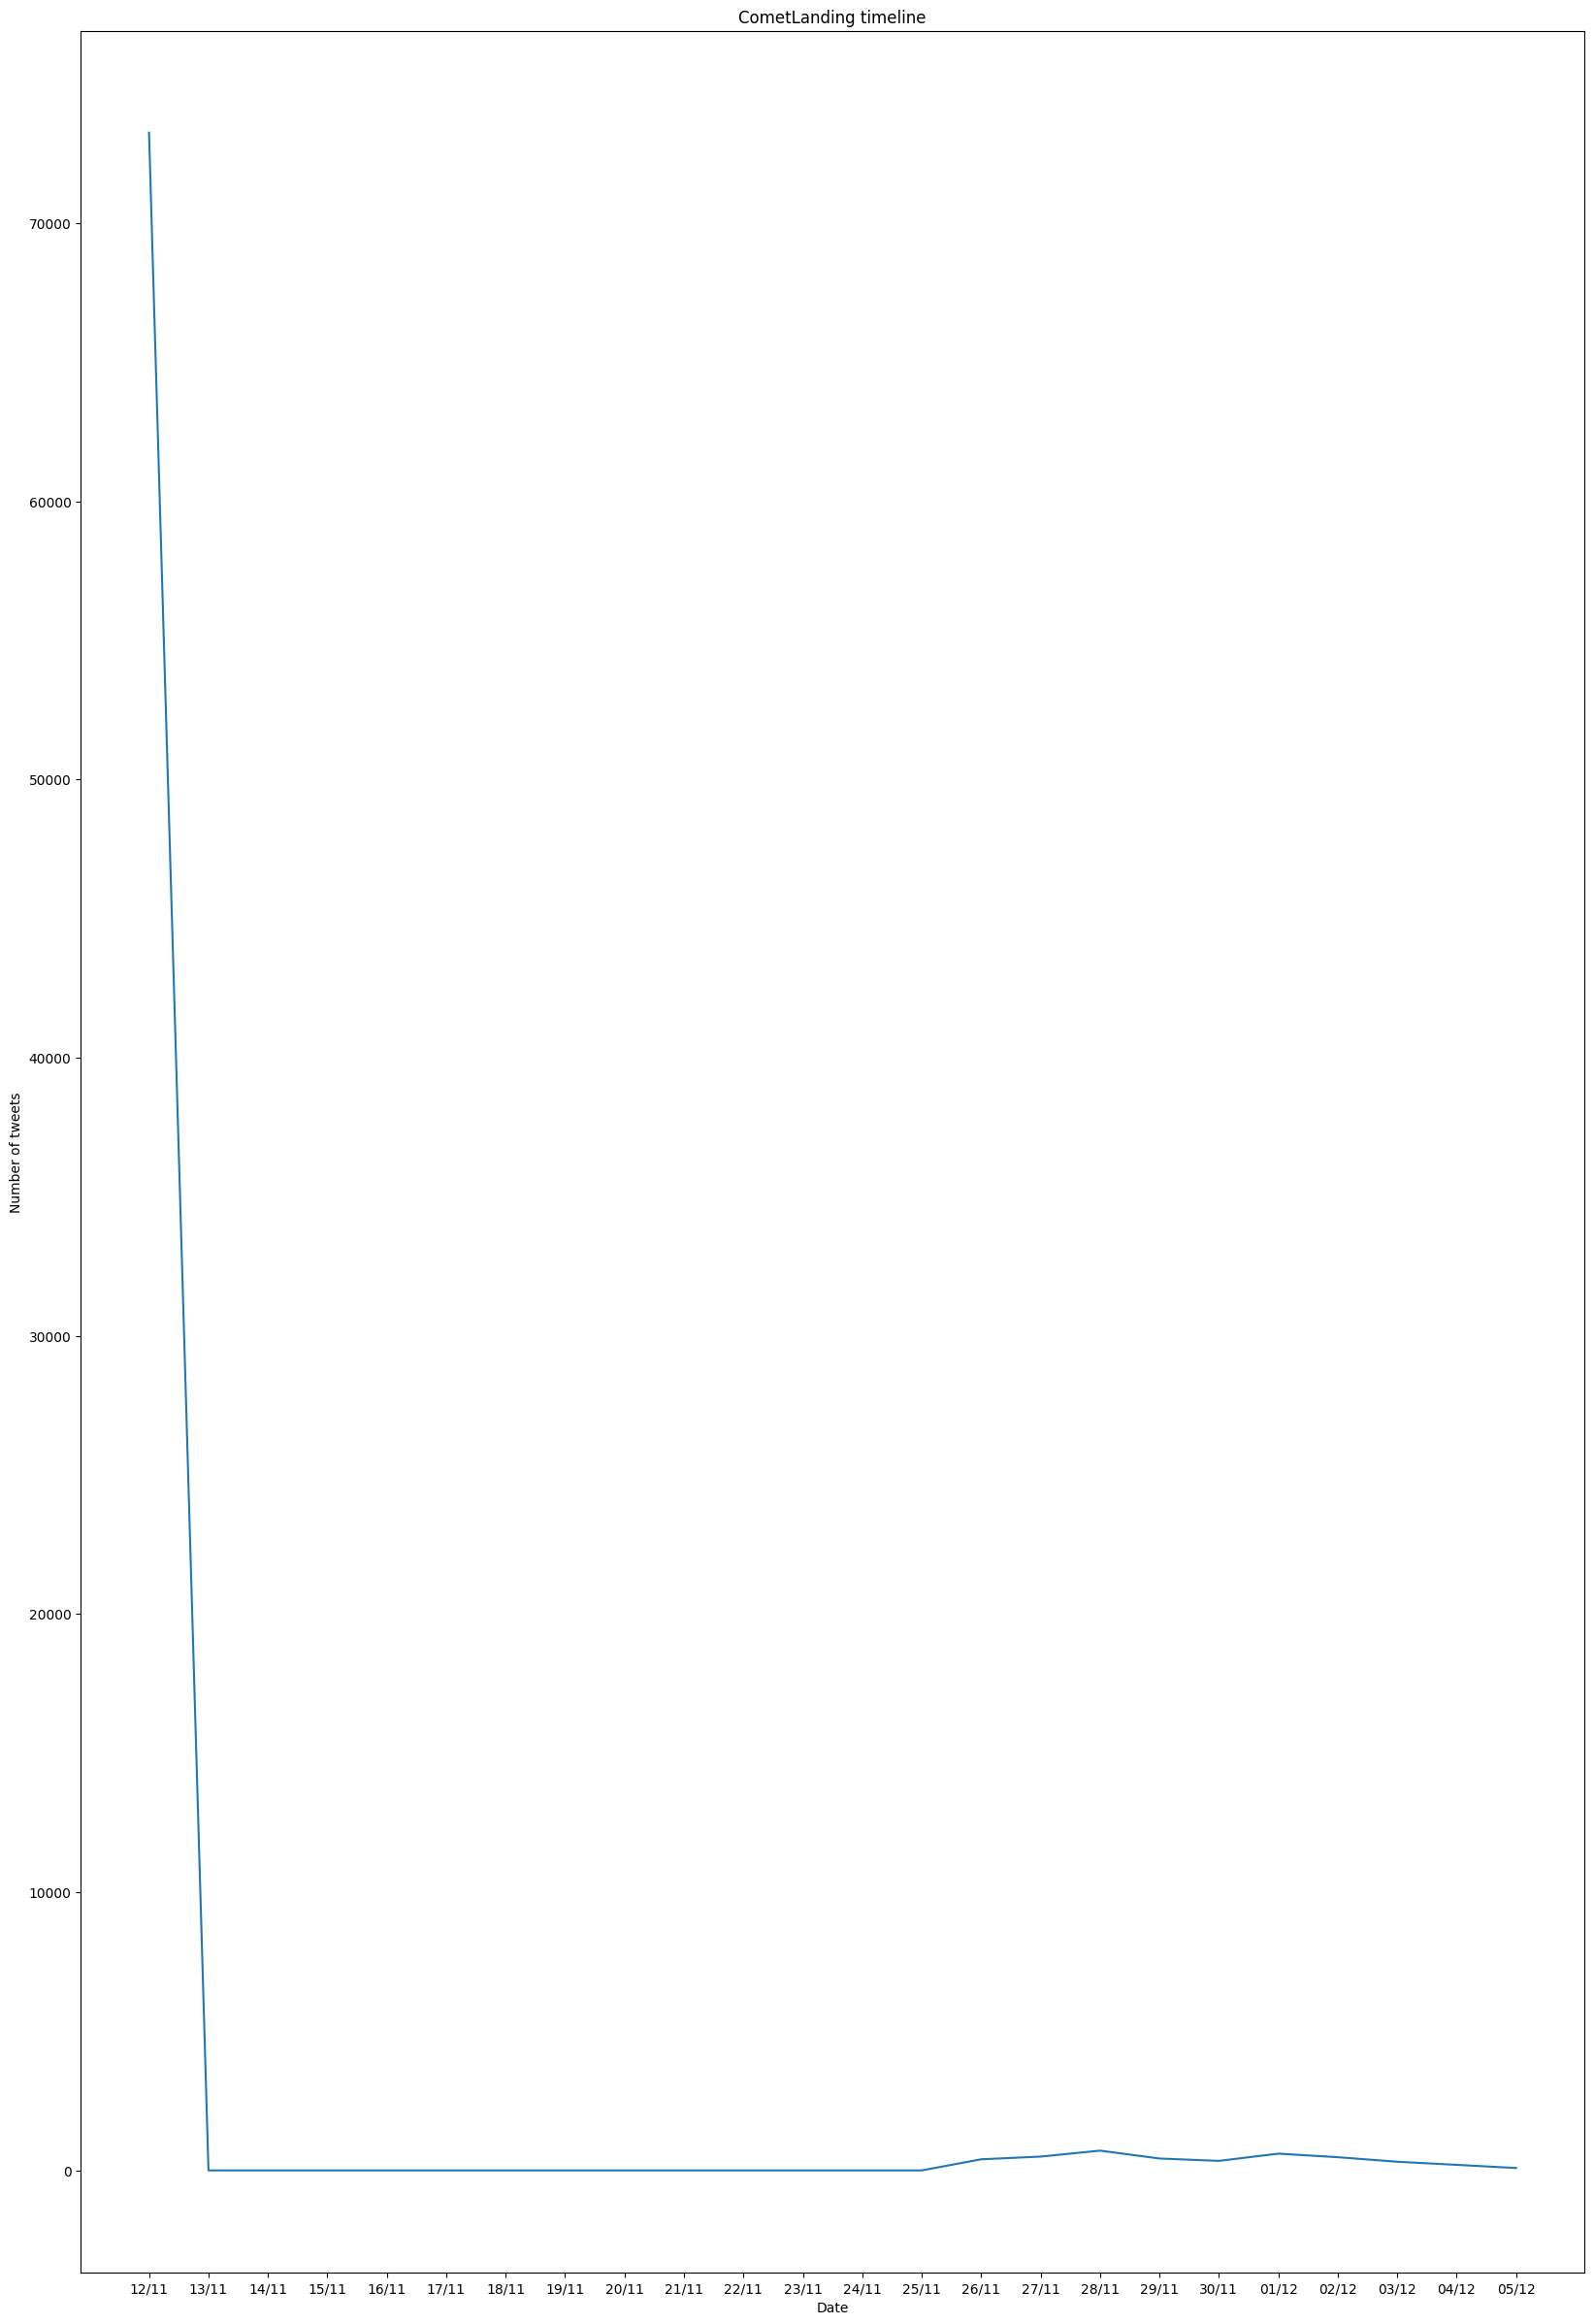

<Figure size 2000x3000 with 0 Axes>

In [76]:
gg.createDailyTimelinePlot(df)
plt.show()
plt.clf()

In [77]:
# in_reply_to_user_id_str
reply_no = len(total_replies)

In [78]:
replied_users = set(total_replies["in_reply_to_user_id_str"]) # set of users receiving a reply
all_users = set(df["from_user_id_str"]).union(replied_users) # set of users that either sent/reply/retweet a tweet or received a reply
normal_with_reply_users = set(df["from_user_id_str"]).intersection(replied_users)
print("Average number of reply received by each user: " + str(len(total_replies) / len(all_users)))
print("Average number of reply received by each replied user: " + str(len(total_replies)/len(replied_users)))

Average number of reply received by each user: 0.03408731414109459
Average number of reply received by each replied user: 2.1576971214017524


In [79]:
print("Number of users received reply: " + str(len(replied_users)))
print("Number of users who tweet/reply/retweet: " + str(len(set(df["from_user_id_str"]))))
print("Number of users either send/reply/retweet or received a reply: " + str(len(all_users)))

Number of users received reply: 799
Number of users who tweet/reply/retweet: 50216
Number of users either send/reply/retweet or received a reply: 50576


In [80]:
# get replies that are to users that have also tweeted/replied/retweeted
replies_to_from_users = total_replies[total_replies["in_reply_to_user_id_str"].isin(set(df["from_user_id_str"]))]
print("Average number of reply received by each user that has also tweeted/replied/retweeted: "
     + str(len(replies_to_from_users)/len(set(df["from_user_id_str"]))))

Average number of reply received by each user that has also tweeted/replied/retweeted: 0.026186872709893262


In [87]:
%matplotlib inline
#data
date_list_raw = [str(ts.strftime("%Y-%m-%d"))for ts in day.count()["id_str"].index.tolist()]
date_list = [] # Dates with tweets
date_data_list = []
date_label_list = []

for d in date_list_raw:
    date_raw = df[df['created_at'].apply(lambda x: True if re.search('^'+d, str(x)) else False)]
    date = date_raw.set_index('created_at').groupby(pd.Grouper(freq='H'))
    date_labels = [str(ts.strftime("%H"))for ts in date.count()["id_str"].index.tolist()]
    date_data = date.count()["id_str"].tolist()
    
    if(len(date_data) > 0 ):
        date_list.append(d) # append dates that contains tweets
        date_data_list.append(date_data)
        date_label_list.append(date_labels)



#graph
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)
l, = plt.plot(date_label_list[0], date_data_list[0], lw=2)

class Index:
    
    def __init__(self):
        self.i = 0
        self.draw_graph()

    def next(self, event):
        self.i = (self.i + 1) % len(date_list)
        self.draw_graph()
  
        
            
    def prev(self, event):
        self.i -= 1
        if(self.i == -1): 
            self.i= len(date_list)-1
        self.draw_graph()
    
    def draw_graph(self):
        
        plt.clf()
        plt.title("CometLanding timeline " + date_list[self.i])
        plt.xlabel("Hour")
        plt.ylabel("Tweets")
        plt.plot(date_label_list[self.i], date_data_list[self.i])
        plt.draw()
        
        
       
        axprev = plt.axes([0.7, 0.05, 0.1, 0.075])  #Button position
        axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) #Button position
        self.bnext = Button(axnext, 'Next') 
        self.bnext.on_clicked(self.next)
        self.bprev = Button(axprev, 'Previous')
        self.bprev.on_clicked(self.prev)
        
        
        

Index()
plt.show()

Using matplotlib backend: MacOSX


In [82]:
# takes a few minutes to complete

# get retweets
retweets = df[df['text'].apply(
    lambda x: True if re.search("^RT @.*", x) else False)]

retweeted_user = dict() # key = user_id, value = no. being retweeted
with open('../data/CometLandingFixed.json', 'r', encoding="utf8") as json_file:
        json_load = json.load(json_file)
        print (len(json_load))
        
        # check entities_str for each tweet
        for x in range(len(json_load)):
            # if current checked entities_str belongs to a retweet
            if (x in retweets.index):
                user = json_load[x]["user_mentions"][0]["id_str"] # get user id
                cur_rt = retweeted_user.setdefault(user, 0) # get recorded no. user being retweeted
                retweeted_user.update({user: cur_rt + 1}) # update no. user being retweeted
                
                # break loop if already reached last retweet
                if (x == max(retweets.index)):
                    break
            else:
                continue
        
json_file.close()

from_user = set(df["from_user_id_str"]) # set of unique id of from_users
# no. of users that are either retweeted or have tweeted/retweeted/replied
all_users_with_rt = len(from_user.union(retweeted_user.keys())) 
# https://www.datacamp.com/community/tutorials/python-dictionary-comprehension
# users that are retweeted and have tweeted/retweeted/replied with no. being retweeted
retweeted_from_user = {user: rt for (user, rt) in retweeted_user.items() if user in set(df["from_user_id_str"])}

77307


In [83]:
print("Average no. each retweeted user being retweeted: " + str(len(retweets)/len(retweeted_user)))
print("Average no. each user being retweeted: " + str(len(retweets)/all_users_with_rt))
print("Average no. each user that has tweeted/retweeted/replied being retweeted: " + 
     str(sum(retweeted_from_user.values()) / len(from_user)))

Average no. each retweeted user being retweeted: 12.449958471760798
Average no. each user being retweeted: 1.149983697424193
Average no. each user that has tweeted/retweeted/replied being retweeted: 1.002290106738888


In [84]:
print("No. of retweets: " + str(len(retweets)))
print("No. of retweets where retweeted user has tweeted/retweeted/replied: " + str(sum(retweeted_from_user.values())))
print("No. of users being retweeted: " + str(len(retweeted_user)))
print("No. of users that are either tweeted or has tweeted/retweeted/replied: " + str(all_users_with_rt))
print("No. of users that are tweeted and has tweeted/retweeted/replied: " + str(len(retweeted_from_user)))

No. of retweets: 59959
No. of retweets where retweeted user has tweeted/retweeted/replied: 50331
No. of users being retweeted: 4816
No. of users that are either tweeted or has tweeted/retweeted/replied: 52139
No. of users that are tweeted and has tweeted/retweeted/replied: 2893


In [85]:
retweet_reply = total_replies[total_replies['text'].apply(lambda x: True if re.search("^RT @.*",x) else False)]

In [86]:
len(retweet_reply)

30

In [16]:
%matplotlib inline